In [1]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import pandas as pd
from classes import TextTokenizer
import math
import os
import urllib.request


GPT124M_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True,
    "batch_size": 8,
    "learning_rate": 0.0004,
    "weight_decay": 0.1
}

SEED = 19
NUM_SENTIMENT_CLASSES = 2
print(f"Is CUDA available: {torch.cuda.is_available()}")

Is CUDA available: True


## Loading GPT2 small model (124M)

In [2]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = torch.nn.Linear(d_out, d_out)
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec


class LayerNorm(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            torch.nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = torch.nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = torch.nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = torch.nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = torch.nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = torch.nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = torch.nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [3]:
file_name = "models/gpt2-small-124M.pth"
file_path = f"models/{file_name}"
url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_path):
    urllib.request.urlretrieve(url, file_path)
    print(f"Downloaded to {file_path}")

model = GPTModel(GPT124M_CONFIG)
model.load_state_dict(torch.load(file_name, weights_only=True))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

## Preparation to train model

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, csv_file, tt: TextTokenizer, max_length=None, pad_token_id=50256):
        self.df = pd.read_csv(csv_file, encoding="utf-8")

        self.encoded_texts = [tt.encode(txt) for txt in self.df["text"]]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_txt[:self.max_length] for encoded_txt in self.encoded_texts]

        self.encoded_texts = [
            encoded_txt + [pad_token_id] * (self.max_length - len(encoded_txt))
            for encoded_txt in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        sentiment = self.df.iloc[index]["sentiment"]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(sentiment, dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length

        return max_length


def create_dataloader(file, tt: TextTokenizer, batch_size=16, shuffle=True, drop_last=True, num_workers=0):
    csv_file = f"dataset/new_sentiment_data/{file}"
    model_dataset = SentimentDataset(csv_file, tt)
    dataloader = DataLoader(model_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


def prepare_model_layers(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.trf_blocks[-1].parameters():
        param.requires_grad = True

    for param in model.final_norm.parameters():
        param.requires_grad = True

    model.out_head = torch.nn.Linear(
    in_features=GPT124M_CONFIG["emb_dim"],
    out_features=NUM_SENTIMENT_CLASSES
)


def plot_values(epoch_seen, train_values, val_values, label="loss"):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(epoch_seen, train_values, label=f"Training {label}")
    ax.plot(epoch_seen, val_values, label=f"Validation {label}", linestyle="-.")
    ax.set_title(label.capitalize())
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label.capitalize())

    ax.legend()
    fig.tight_layout()
    plt.show()

In [5]:
tt = TextTokenizer(tokenizer=tiktoken.get_encoding("gpt2"))
batch_size = 256 #8
num_workers = 0

torch.manual_seed(SEED)
train_loader = create_dataloader("train.csv", tt, batch_size, True, True, num_workers)
val_loader = create_dataloader("validation.csv", tt, batch_size, False, True, num_workers)
test_loader = create_dataloader("test.csv", tt, batch_size, False, False, num_workers)

prepare_model_layers(model)

In [6]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]

            probs = torch.softmax(logits, dim=-1)
            predicted_labels = torch.argmax(probs, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += ((predicted_labels == target_batch).sum().item())

        else:
            break

    return correct_predictions / num_examples


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)

    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break

    return total_loss / num_batches


def train_sentiment(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step, epoch_step = 0, -1, -1

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1
            epoch_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                print(f"Ep {epoch+1}/{num_epochs} "
                    f"(Step {int(math.ceil(epoch_step/eval_freq))}/{int(math.ceil(len(train_loader)/eval_freq))} [{(epoch_step/len(train_loader) * 100):.2f}%]): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

                train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
                val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

                print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
                print(f"Validation accuracy: {val_accuracy*100:.2f}%")
                train_accs.append(train_accuracy)
                val_accs.append(val_accuracy)

        epoch_step = -1

    return train_losses, val_losses, train_accs, val_accs, examples_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)

    model.train()
    return train_loss, val_loss

## Model training

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 1
model.to(device)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_sentiment(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=25,
    eval_iter=5
)

Ep 1/1 (Step 0/180 [0.00%]): Train loss 0.806, Val loss 0.799
Training accuracy: 51.64% | Validation accuracy: 49.14%
Ep 1/1 (Step 1/180 [0.56%]): Train loss 0.694, Val loss 0.693
Training accuracy: 50.31% | Validation accuracy: 49.14%
Ep 1/1 (Step 2/180 [1.12%]): Train loss 0.691, Val loss 0.693
Training accuracy: 50.55% | Validation accuracy: 49.30%
Ep 1/1 (Step 3/180 [1.67%]): Train loss 0.670, Val loss 0.673
Training accuracy: 60.62% | Validation accuracy: 60.55%
Ep 1/1 (Step 4/180 [2.23%]): Train loss 0.603, Val loss 0.628
Training accuracy: 67.27% | Validation accuracy: 66.17%
Ep 1/1 (Step 5/180 [2.79%]): Train loss 0.554, Val loss 0.559
Training accuracy: 71.09% | Validation accuracy: 71.33%
Ep 1/1 (Step 6/180 [3.35%]): Train loss 0.524, Val loss 0.545
Training accuracy: 73.75% | Validation accuracy: 72.34%
Ep 1/1 (Step 7/180 [3.91%]): Train loss 0.559, Val loss 0.539
Training accuracy: 73.98% | Validation accuracy: 72.89%
Ep 1/1 (Step 8/180 [4.47%]): Train loss 0.521, Val loss 

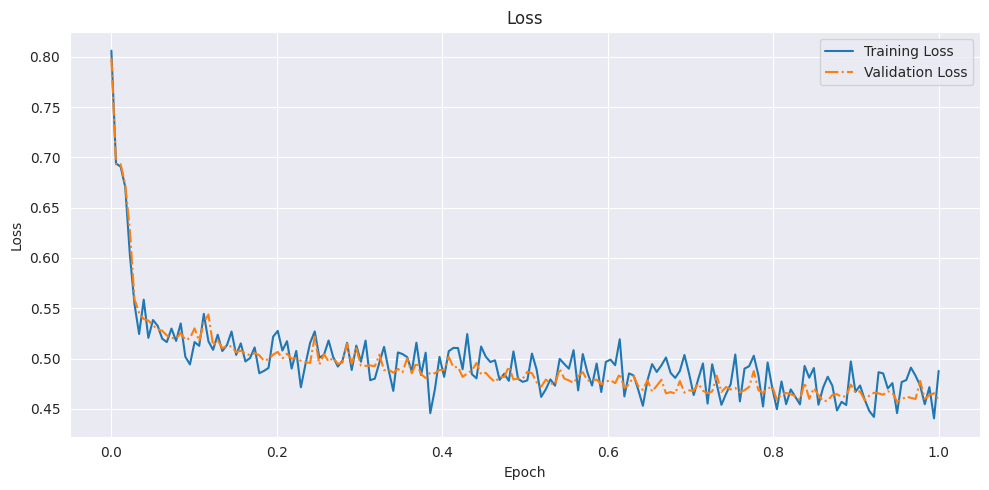

In [8]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses)).to("cpu")
plot_values(epochs_tensor, [item.to("cpu") for item in train_losses], [item.to("cpu") for item in val_losses], "Loss")

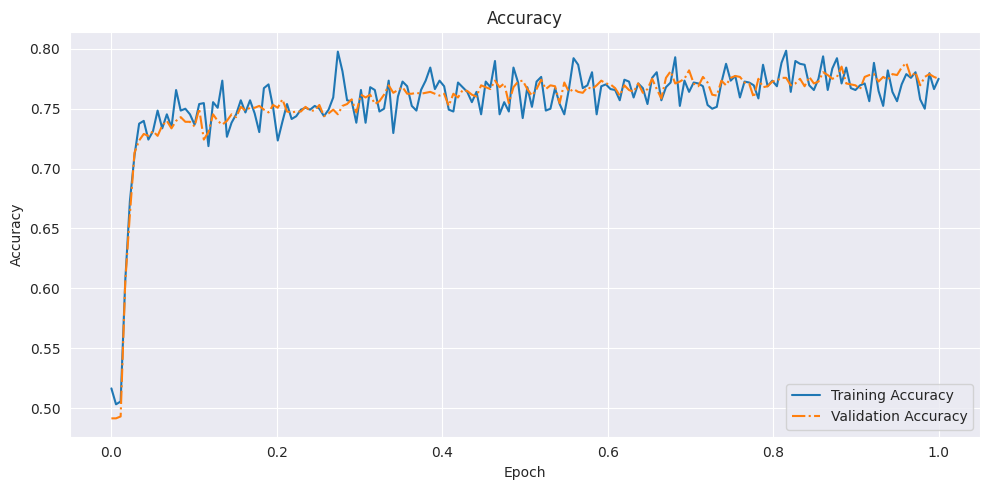

In [9]:
plot_values(epochs_tensor, train_accs, val_accs, "Accuracy")

In [10]:
model.eval()
test_acc = calc_accuracy_loader(test_loader, model, device)

print(f"Test accuracy: {test_acc*100:.2f}%")

Test accuracy: 77.48%


## Model saving

In [11]:
def save_model(model, optimizer=None, filename="model"):
    # filename with no extension
    if optimizer is None:
        torch.save(model.state_dict(), f"models/{filename}_MODEL.pth")
    else:
        torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"models/{filename}_MODEL-OPTIMIZER.pth"
        )


def load_model(filepath, config, device, with_optimizer=False):
    checkpoint = torch.load(filepath, map_location=device)
    model = GPTModel(config)

    if not with_optimizer:
        model.load_state_dict(checkpoint)
        model.train()
        return model

    model.load_state_dict(checkpoint["model_state_dict"])
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    return model, optimizer

In [12]:
save_model(model, None, "gpt124m_sentiment")
save_model(model, optimizer, "gpt124m_sentiment")